# Tutorial 01 - Intro to Keras models

## Step 1: imports etc

This is pretty much the same as the previous tutorial -- very often your imports will look just like this.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import keras
import keras.backend as K
import keras.layers as layers
from keras.models import Model

Using TensorFlow backend.


In [4]:
from keras.datasets import mnist

One thing we will do a bit differently, is to scale the image data to the range (0,1) right away.
Generally NN's prefer to work with numbers between (0,1) or (-1,1).

In [5]:
(X_train, y_train), (X_val, y_val) = mnist.load_data()

X_train = X_train / 255.
X_val = X_val / 255.

## Step 2: Basic model

We're going to build a classic autoencoder.
It will consist of just a few dense layers in the encoder reducing the image the a low-dimensional representation, and a few layers for the decoder to restore the original image.

In [6]:
def mk_autoencoder(n_units=128, n_layers=2, latent_dim=2):
    K.clear_session()
    
    auto_input = layers.Input((28,28))
    H = auto_input
    print(H.shape)
    
    # The dense layers will regard our data as a single vector.
    # Dense layers (a.k.a. fully-connected layers) don't really care about the shape,
    # since every output unit of the dense layer is connected to every input value.
    # So to make it work with a 2D array, we can simply use a Reshape layer to
    # "flatten" our 2D iamges into an equivalently-sized 1D vector.
    H = layers.Reshape((28*28,))(H)
    print(H.shape)
    
    #########
    ## Encoder part of the network
    #########
    
    for i in range(n_layers):
        H = layers.Dense(n_units, activation='relu')(H)
        print(H.shape)
    
    # The output of this layer will be the "encoded" representation of the
    # input. It has whatever dimensionality was specified by `latent_dim`.
    H = layers.Dense(latent_dim)(H)
    print(H.shape)
    
    #########
    ## Decoder part of the network
    #########
    
    # Now that low-dimensional data is fed into some more NN layers,
    # and with a final large dense layer, it will be restored to the original size.
    for i in range(n_layers):
        H = layers.Dense(n_units, activation='relu')(H)
        print(H.shape)
    
    # Note that for the final NN layer, we use a sigmoid output,
    # which is gauranteed to give a number between (0,1).
    H = layers.Dense(28*28, activation='sigmoid')(H)
    
    # Finally, reshape the data back into a 2D image format:
    H = layers.Reshape((28,28))(H)
    
    auto_output = H
    
    # Now we can we build a Keras model by connecting the input layer to the output layer.
    auto = Model(auto_input, auto_output)
    
    # Since we are now working with proper NN layers, this model has trainable parameters
    # that will need to be learned by fitting to data.
    # In order to do this, we must specify a loss function, which indicates how well
    # the input matches the output, as well as an optimizer strategy for Keras to 
    # use to update the parameters.
    # Both of these can be specified at once using the compile function, which
    # should be called once after the model is built but before training begins.
    # We will use the Mean Squared Error loss function, and the adam optimizer.
    # Generally, a lot of thought needs to go into selecting a loss function;
    # however for the optimizer, we can usually just use the Adam method and
    # forget about it.
    
    auto.compile(loss='mse', optimizer='adam')
    
    return auto

In [7]:
model = mk_autoencoder()
model.summary()

(?, 28, 28)
(?, 784)
(?, 128)
(?, 128)
(?, 2)
(?, 128)
(?, 128)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
_________________________________________________________________
dense_4 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_5 (Den

Note that our autoencoder model has a few hundred thousand parameters, which is not that surprising as dense networks can rack up parameters very quickly.
Now that we have built and compiled a model, we can train all those parametes by using Keras' `fit` function, which makes it more or les automatic.

The first argument to the `fit` function is the input data, and the second argument is the target value for the MSE loss.
In this case, since it is an autoencoder, the input value and target output value are of course identical.

The NN will compute its output for the given input data, and then Keras will compare that to the actual input data by calculating the mean squared error between the two.
The Adam algorithm will then determine an adjustment to the parameters of the neural network in order to try and reduce the MSE on the next pass.

This procedure is repeated over and over on batches of 64 images, until the whole dataset of 60,000 images has been covered. This is called one epoch.
After the epoch, Keras prints out some statistics about the training time, the average (MSE) loss value, etc.
The whole process is then repeated, for however many epochs were requested.

In [8]:
batch_size = 64
epochs = 8

model.fit(X_train, X_train, validation_data=(X_val, X_val),
          batch_size=batch_size, epochs=epochs)

Train on 60000 samples, validate on 10000 samples
Epoch 1/8
60000/60000 [==============================] - 5s 84us/step - loss: 0.0568 - val_loss: 0.0468
Epoch 2/8
60000/60000 [==============================] - 5s 75us/step - loss: 0.0450 - val_loss: 0.0434
Epoch 3/8
60000/60000 [==============================] - 5s 81us/step - loss: 0.0425 - val_loss: 0.0416
Epoch 4/8
60000/60000 [==============================] - 5s 91us/step - loss: 0.0410 - val_loss: 0.0405
Epoch 5/8
60000/60000 [==============================] - 5s 81us/step - loss: 0.0400 - val_loss: 0.0397
Epoch 6/8
60000/60000 [==============================] - 5s 89us/step - loss: 0.0394 - val_loss: 0.0393
Epoch 7/8
60000/60000 [==============================] - 6s 105us/step - loss: 0.0389 - val_loss: 0.0389
Epoch 8/8
60000/60000 [==============================] - 6s 98us/step - loss: 0.0384 - val_loss: 0.0383


After eight epochs, we havea loss of about 0.38.

It's hard to intit what exactly that means, so let's just visualize the autoencoder performance by plotting some test images versus the autoencoded version. First, we have to use the `predict` function to have the autoencoder compute a few autoencoded images:

In [9]:
X_pred = model.predict(X_val[:4])
print(X_pred.shape)

(4, 28, 28)


Note that the predicted output values have the same shape as the input. Let's have a look to see if they also _look_ the same (which is the autoencoder's goal).

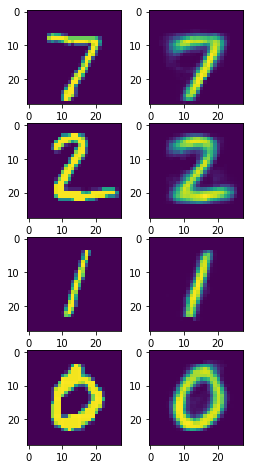

In [10]:
plt.figure(figsize=(4,8))
for i in range(4):
    plt.subplot(4,2,2*i+1)
    plt.imshow(X_val[i])
    plt.subplot(4,2,2*i+2)
    plt.imshow(X_pred[i])

Not too bad, considering that each image was compressed to just two numbers! You can see the NN is failing a bit; for example the 2 may look a bit like an 8. Or the detailed pen stroke at the top of the zero may not be successfully reproduced by the AE.

Please take a minute and play around with the _hyperparameters_ of the autoencoder, by tweaking the arguments to the `mk_autoencoder` function. For example, let's see what happens if we increase the dimensionality of the latent dimension:

In [11]:
model = mk_autoencoder(n_units=128, n_layers=2, latent_dim=16)
model.summary()

(?, 28, 28)
(?, 784)
(?, 128)
(?, 128)
(?, 16)
(?, 128)
(?, 128)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_5 (De

Note, by the way, that you can re-run the `fit` function, and the NN will continue learning where it left off.
Howver, since we used `K.clear_session()` in the builder function, any NN learning will be reset each time the `mk_autoencoder` function is run.

In [12]:
batch_size = 64
epochs = 8

model.fit(X_train, X_train, validation_data=(X_val, X_val),
          batch_size=batch_size, epochs=epochs)

Train on 60000 samples, validate on 10000 samples
Epoch 1/8
60000/60000 [==============================] - 5s 87us/step - loss: 0.0349 - val_loss: 0.0202
Epoch 2/8
60000/60000 [==============================] - 5s 90us/step - loss: 0.0181 - val_loss: 0.0160
Epoch 3/8
60000/60000 [==============================] - 5s 79us/step - loss: 0.0156 - val_loss: 0.0151
Epoch 4/8
60000/60000 [==============================] - 5s 77us/step - loss: 0.0144 - val_loss: 0.0137
Epoch 5/8
60000/60000 [==============================] - 5s 82us/step - loss: 0.0135 - val_loss: 0.0129
Epoch 6/8
60000/60000 [==============================] - 5s 85us/step - loss: 0.0129 - val_loss: 0.0125
Epoch 7/8
60000/60000 [==============================] - 5s 90us/step - loss: 0.0124 - val_loss: 0.0120
Epoch 8/8
60000/60000 [==============================] - 6s 93us/step - loss: 0.0120 - val_loss: 0.0117


(4, 28, 28)


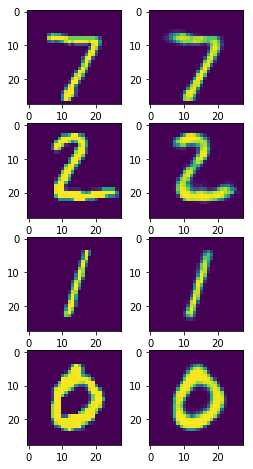

In [13]:
X_pred = model.predict(X_val[:4])
print(X_pred.shape)
plt.figure(figsize=(4,8))
for i in range(4):
    plt.subplot(4,2,2*i+1)
    plt.imshow(X_val[i])
    plt.subplot(4,2,2*i+2)
    plt.imshow(X_pred[i])

Ask yourself what effect tweaking the various parameters has. How does the batch size affect the autoencoder performance?
Note that both increasing `n_units` and `n_layers` will increase the number of parameters. Do these two settings have different effects?

How does the batch size affect training time? Does training for longer always improve the performance, or does it slow down (or even reverse) at some point? Remember usually only the validation performance is what matters.

## Step 3: Composing models

The above is a perfectly functional autoencoder. However, it's often interesting to look at the latent space of the autoencoder. In the current design, there is no easy way to do this.

Keras allows us to factorize models into smaller pieces, and then compose those models into bigger ones. Let's illustrate this by building separate encoder and decoder models, and the joining them into a single autoencoder:

In [14]:
def mk_autoencoder2(n_units=128, n_layers=2, latent_dim=2):
    K.clear_session()
    
    #########
    ## First, make a stand-alone encoder model
    #########
    
    encoder_input = layers.Input((28,28))
    H = encoder_input
    print(H.shape)
    
    H = layers.Reshape((28*28,))(H)
    print(H.shape)
    
    for i in range(n_layers):
        H = layers.Dense(n_units, activation='relu')(H)
        print(H.shape)
    
    H = layers.Dense(latent_dim)(H)
    encoder_output = H
    
    encoder = Model(encoder_input, encoder_output)
    
    #########
    ## Now a stand-alone decoder:
    #########
    
    # Note that we need to make an Input layer, but this time
    # it will need to have the same shape as the latent space:
    
    decoder_input = layers.Input((latent_dim,))
    H = decoder_input
    
    for i in range(n_layers):
        H = layers.Dense(n_units, activation='relu')(H)
        print(H.shape)
    
    H = layers.Dense(28*28, activation='sigmoid')(H)
    
    H = layers.Reshape((28,28))(H)
    
    decoder_output = H
    
    decoder = Model(decoder_input, decoder_output)
    
    
    #########
    ## Finally, we can "glue" the two models together into a third model
    ## to create the autoencoder.
    #########
    
    # Note the autoencoder will need its own Input layer, since the data
    # will "flow" differently and Keras needs to track it:
    
    auto_input = layers.Input((28,28))
    
    # we can apply the encoder model in much the same way we apply
    # Keras layers, in order to get a tensor representing the encoded
    # representation (the latent or encoded representation is often
    # denoted as `z`):
    
    auto_z = encoder(auto_input)
    
    # Now, we take that encoded tensor and apply the decoder to it, to
    # calculate the final output:
    
    auto_output = decoder(auto_z)
    
    # Note, this could have been written even more concisely as:
    # auto_output = decoder(encoder(auto_input))
    
    # Finally, as always we need to build a Keras model and tell it where
    # the starting and ending points are:
    auto = Model(auto_input, auto_output)
    
    # We can compile the autoencoder model as before. Since we will not directly train
    # the encoder and decoder, they will not be compiled.
    auto.compile(loss='mse', optimizer='adam')
    
    # Now we return all three networks, so they can be used individually:
    return encoder, decoder, auto

We can initialize the three networks, and print a summary of each. Note that the parameters of encoder and decoder also parameters of the autoencoder, and visa versa.

In [15]:
encoder, decoder, auto = mk_autoencoder2()
encoder.summary()
decoder.summary()
auto.summary()

(?, 28, 28)
(?, 784)
(?, 128)
(?, 128)
(?, 128)
(?, 128)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 117,250
Trainable params: 117,250
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type) 

Now let us train the autoencoder as before:

In [16]:
batch_size = 64
epochs = 8

auto.fit(X_train, X_train, validation_data=(X_val, X_val),
          batch_size=batch_size, epochs=epochs)

Train on 60000 samples, validate on 10000 samples
Epoch 1/8
60000/60000 [==============================] - 5s 80us/step - loss: 0.0574 - val_loss: 0.0476
Epoch 2/8
60000/60000 [==============================] - 5s 77us/step - loss: 0.0455 - val_loss: 0.0438
Epoch 3/8
60000/60000 [==============================] - 5s 78us/step - loss: 0.0427 - val_loss: 0.0420
Epoch 4/8
60000/60000 [==============================] - 5s 89us/step - loss: 0.0412 - val_loss: 0.0406
Epoch 5/8
60000/60000 [==============================] - 5s 78us/step - loss: 0.0401 - val_loss: 0.0396
Epoch 6/8
60000/60000 [==============================] - 5s 78us/step - loss: 0.0392 - val_loss: 0.0390
Epoch 7/8
60000/60000 [==============================] - 5s 80us/step - loss: 0.0385 - val_loss: 0.0384
Epoch 8/8
60000/60000 [==============================] - 7s 111us/step - loss: 0.0381 - val_loss: 0.0380


(4, 28, 28)


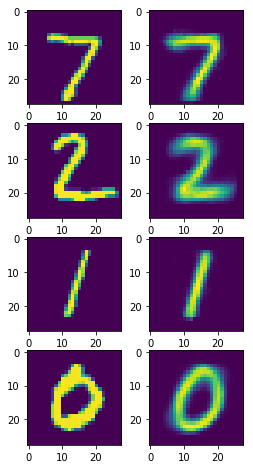

In [17]:
X_pred = auto.predict(X_val[:4])
print(X_pred.shape)
plt.figure(figsize=(4,8))
for i in range(4):
    plt.subplot(4,2,2*i+1)
    plt.imshow(X_val[i])
    plt.subplot(4,2,2*i+2)
    plt.imshow(X_pred[i])

## Step 4: Exploring the latent space

This autoencoder will of course give nearly identical performance as before, since it is essentially equivalent.

However, because of this new implementation, now that we have trained the autoencoder, this means the encoder and decoder have been trained as well. Let's inspect the outputs of the encoder:

In [18]:
z_pred = encoder.predict(X_val)
print(z_pred.shape)

(10000, 2)


For each of the 10000 validation examples, the encoder predicts a 2-dimensional number. A convenient way to visualize these numbers is with a scatter plot:

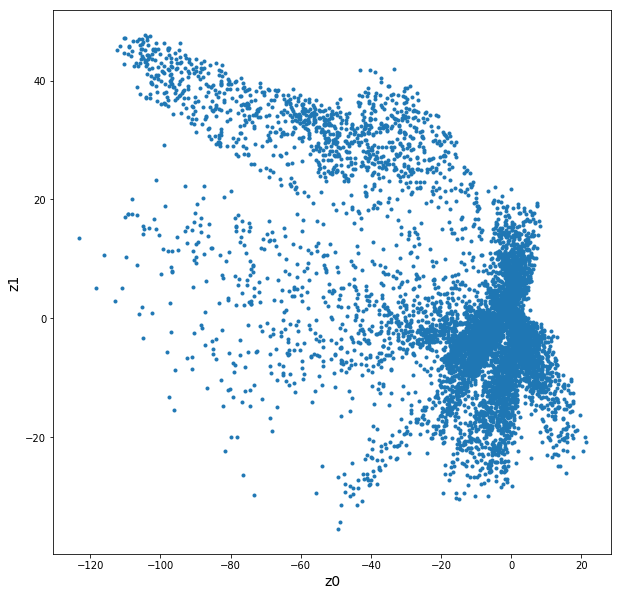

In [19]:
plt.figure(figsize=(10,10))
plt.scatter(z_pred[:,0], z_pred[:,1], marker='.')
plt.xlabel("z0", fontsize=14)
plt.ylabel("z1", fontsize=14);

This plot shows the location each input example in the abstract z0--z1 plane of the encoded 2D space.
Let's use a trick we saw in the previous tutorial to plot the location of different y-values separately:

Avg position for y=1:  [-53.994797  30.719255]


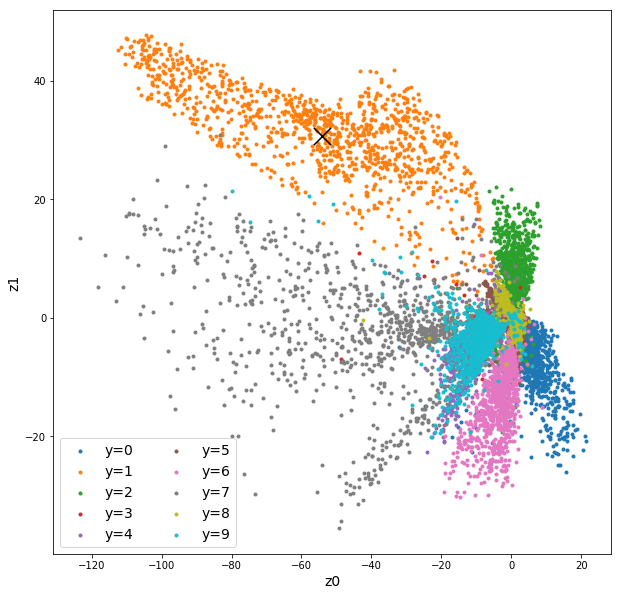

In [20]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.scatter(z_pred[y_val==i][:,0], z_pred[y_val==i][:,1], marker='.', label='y=%d'%i)
plt.xlabel("z0", fontsize=14)
plt.ylabel("z1", fontsize=14)
plt.legend(ncol=2, fontsize=14);
avg_pos = z_pred[y_val==1].mean(axis=0)
plt.scatter(avg_pos[0], avg_pos[1], marker='x', s=300, color='black');
print("Avg position for y=1: ", avg_pos)

Neat! This tells us that the autoencoder learns to put different numbers in different locations in z-space.
Some numbers (like 1), are quite independent in z-space. Other numbers, such as 7 and 9, or 5 and 8, may overlap significantly.
This explains why sometimes, autoencoded iamges of the number 5 might look kind of like a number 8. It also makes sense, since these numbers are kind of similar, so it's harder for the autoencoder to learn to separate them in the compact 2D space.

## Step 5: Crafting forgeries (a.k.a generative modeling)

Thanks to our encoder model, we know something about the latent space. Let's now use the decoder model to _synthesize_ an artificial image.

Try locating a point in z-space that seems to be soundly in the middle of the `y=1` region. This will be different each time your train the autoencoder, so try picking a sensible value by hand. If you're at a loss, I have indicated the average location in z-space in the figure above (indicated by a black `X`, and printed above the figure).

Let's feed this point into the decoder, and see what comes out! Hopefully it should look like a picture of the number 1. Note that this image is completely synthetic; it does not appear in either the training or validation dataset, but is instead a creation of your neural network's imagination.

z_guess shape: (1, 2)
x_fake shape: (1, 28, 28)


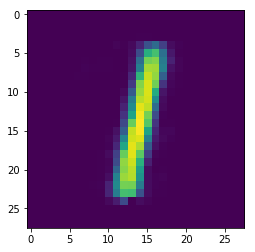

In [23]:
z_guess = np.array([[-54, 31]])

print("z_guess shape:", z_guess.shape)
x_fake = decoder.predict(z_guess)
print("x_fake shape:", x_fake.shape)

plt.imshow(x_fake[0])

Now, try tweaking the value of `z_guess` a bit by hand and see how the output looks. Can you get the decoder to draw, say, the number 6 by picking a suitable point in z-space?

z_guess shape: (1, 2)
x_fake shape: (1, 28, 28)


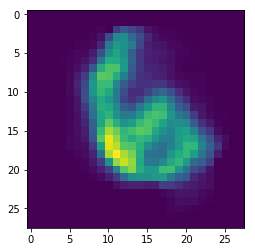

In [22]:
z_guess = np.array([[-5, -8]])

print("z_guess shape:", z_guess.shape)
x_fake = decoder.predict(z_guess)
print("x_fake shape:", x_fake.shape)

plt.imshow(x_fake[0])